
# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Overview
The goal of this project is to build a convolution neural network in Keras that clones a driver's behavior and predicts steering angles from images. The model I built could successfully drive around track one without leaving the road. The following animation shows how the car drives on the lake side track.

[Animation Place holder]()

My project includes the following files:

`model.py` containing the script to create and train the model  
`utils.py` containing all the utilities functions  
`drive.py` for driving the car in autonomous mode  
`model.h5` containing a trained convolution neural network  
`README.md` summarizing the results  

### How to train/retrain the model
Before you train the model, you need to record some driving data in the simulator. Assuming you put the trainning data in *data/track1*, then you could use the following command to train the model:

`python model.py -d data/track1/ -m nvidia -o nvidia_t1 -e 15`

To train a model on several data sets:

`python model.py -d data/track1/:data/track1-1/:data/track1-2/ -m nvidia -o nvidia_t1 -e 15`

To retrain a model on new data sets:

`python model.py -d data/track1-1/ -l nvidia_t1-1 -o nvidia_t1-2 -e 5 &&\`  
`python model.py -d data/track1-2/ -l nvidia_t1-2 -o nvidia_t1-3 -e 5`

To retrain a model with weights only on new data sets:

`python model.py -d data/track1-1/ -m nvidia -w nvidia_t1-1 -o nvidia_t1-2 -e 5 &&\`  
`python model.py -d data/track1-2/ -m nvidia -w nvidia_t1-2 -o nvidia_t1-3 -e 5`


Arguments explaination:  
`-d` Specify the training path  
`-m` Build a new model, you could also choose `lenet`,`commaai`  
`-o` Output model file, the code will save the weights into *.w* file, weights and model into *.h5* file  
`-e` Number of training epochs  
`-r` Learning rate, by default is 0.001  
`-w` Load the weights into the model  
`-l` Load a trained model  

### How to run the model
To run the model, you simply load the model with *drive.py*:

`python drive.py nvidia_t1.h5 -s 30`
Arguments explaination:  
`-s` Set speed, [0,30]  


### How to log the data
Sometime we want to log the data during the test to troubleshoot the model, here's way I used to log the images, steerings, throttle.

`python drive.py nvidia_t1.h5 -s 30 log > log.txt`

Then all the images will be save into the log folder and the file names, steerings, throttle will be save into the log.txt file.


### How to visualize the data
To plot the steering data in the log file:  

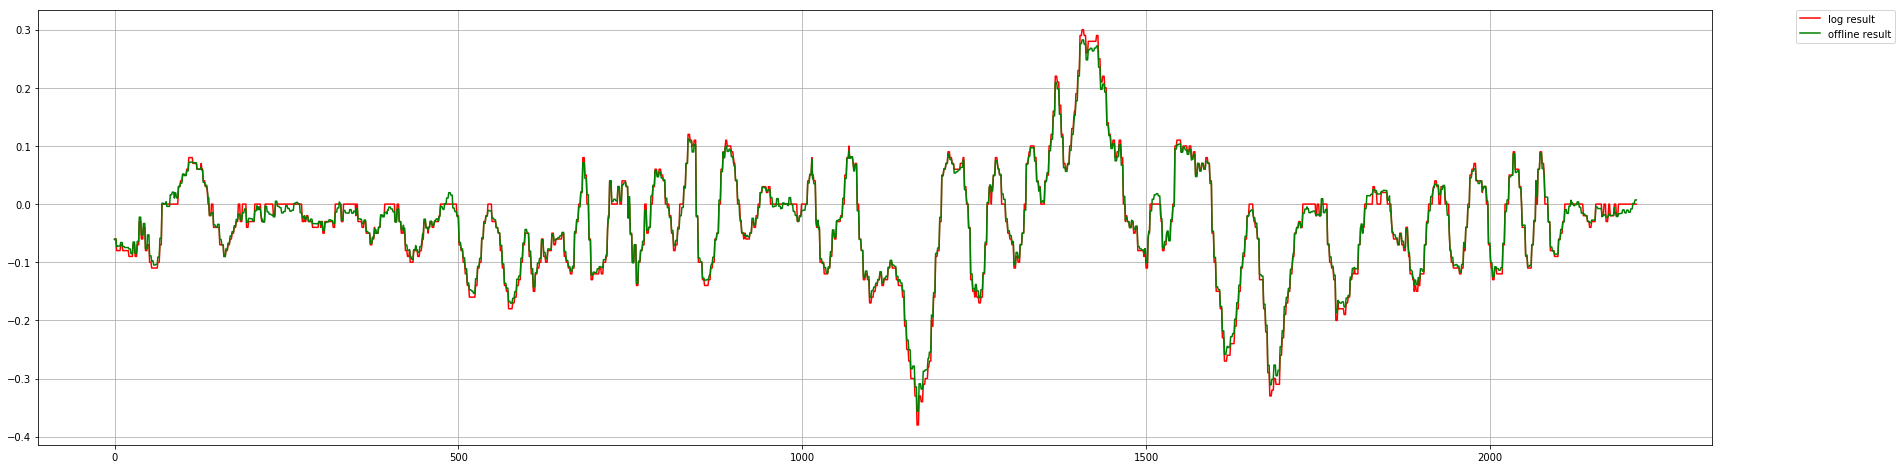

In [2]:
import utils
utils.plot_log("log/","log.txt","nvidia_t1_pro3.h5")

To help analyzing the model, I created a function to overlay the steering data on the images. You could also use the other functions I wrote to make a video or gif.

In [3]:
import utils
utils.visualize_log("log","log.txt","log_vis")
utils.make_video("log_vis")
utils.make_gif("log_vis",10)

Open  2214  files
Creating image folder at log_vis/
Process completed
Creating video log_vis.mp4, FPS=60
[MoviePy] >>>> Building video log_vis.mp4
[MoviePy] Writing video log_vis.mp4


100%|██████████| 2214/2214 [00:05<00:00, 413.76it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: log_vis.mp4 



Image is saved to  log_vis.gif


## Implementation
### Data Preprocessing

Training data was chosen to keep the vehicle driving on the road. I take advantage of three cameras mounted on the car to triple the data. Among these data, I offset the steering angles for left and right images to simulate the recovering maneuvers. Otherwise the car might swerve out of the road due to the steering bias. This also reduce my work to collect the data for recovering as it's very difficult to do so.

The first thing I do in data preprocessing is to crop and resize the image. The original size of the image is 320x160, which includes lots of information out of the road that doesn't affect the driving. Cropping out these part could speed up the training. After some test, I found that croping out 60 pixels from the 40 from the bottom is a good choice. After cropping, the image size is reduce to 80x80 to reduce training time. The code below shows this process.

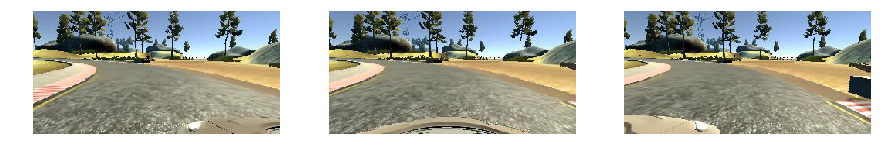

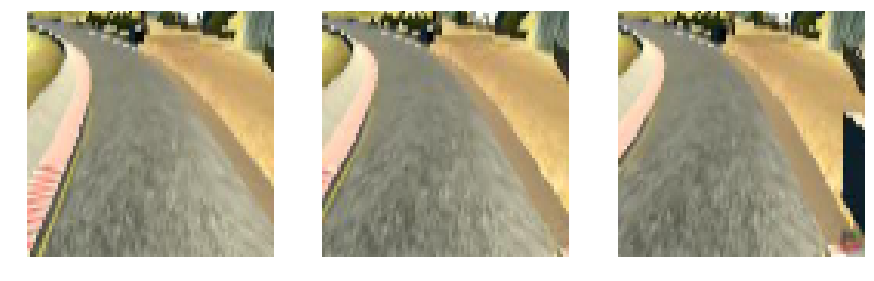

In [6]:
from PIL import Image
import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot(images):
    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.imshow(images[0])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(images[1])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(images[2])
    plt.axis('off')
    plt.show()

%matplotlib inline
# file = "data/track1-center/IMG/center_2017_06_10_00_43_05_338.jpg"
files = ["data/track1-center1/IMG/left_2017_06_10_17_28_39_772.jpg",
         "data/track1-center1/IMG/center_2017_06_10_17_28_39_772.jpg",
         "data/track1-center1/IMG/right_2017_06_10_17_28_39_772.jpg"]

imgs= [Image.open(files[0]),Image.open(files[1]),Image.open(files[2])]
img_cv = [utils.preprocess_image(np.array(imgs[0])),
          utils.preprocess_image(np.array(imgs[1])),
          utils.preprocess_image(np.array(imgs[2]))]
plot(imgs)
plot(img_cv)

The next thing I did was to filter the steering angle. As you can see, the raw steering data is very noisy due to the sensitive keyboard response. This is defintely not how a human would drive in real life. Also, such a noisy data would be very difficult for the model to classify and find the optimal weights. To filter the steering, I used the convolution function from numpy. The following function shows how I smooth and offset the steering angles.

The third figure below shows the distribution of steerings angles. As we can see, the number of the straight steering data is way more than other data. If we train our network on this the model could overfit to the straight steering data and won't steer enough at corners. The way I solved this problem was to down sample the number of straight steering data by some factor. Since the track one is quite simple it didn't show much effect but it does improved the performance on the track two.

Using TensorFlow backend.


Read  4305


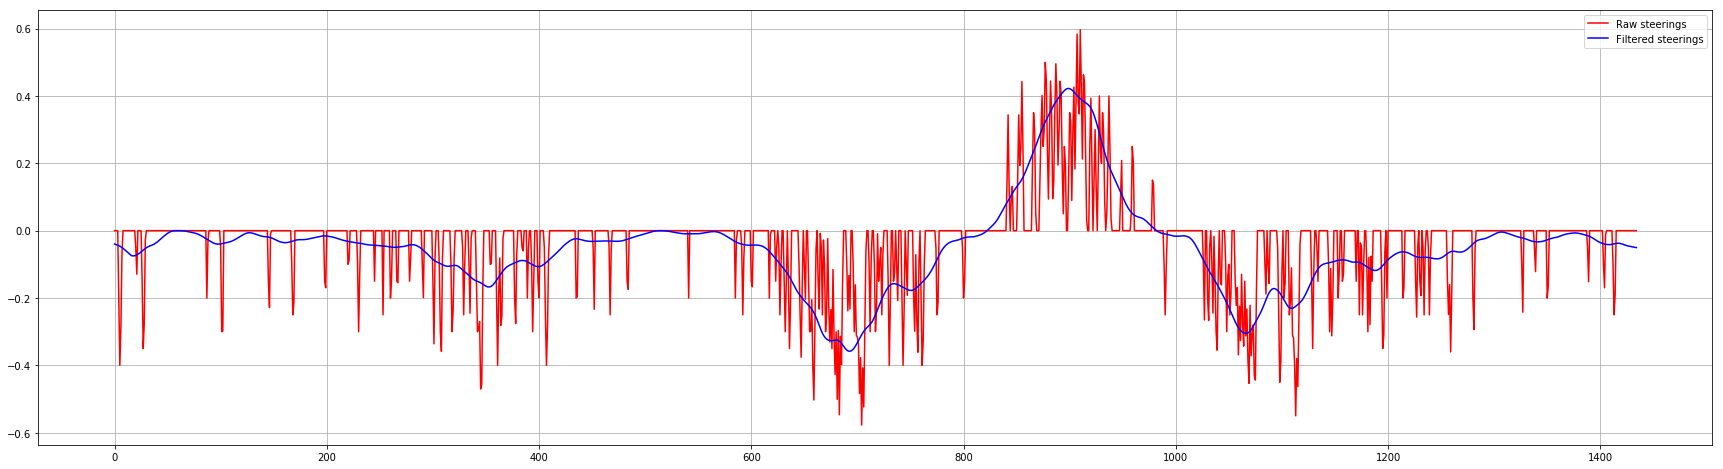

Samples are reduce from  4305  to  3859


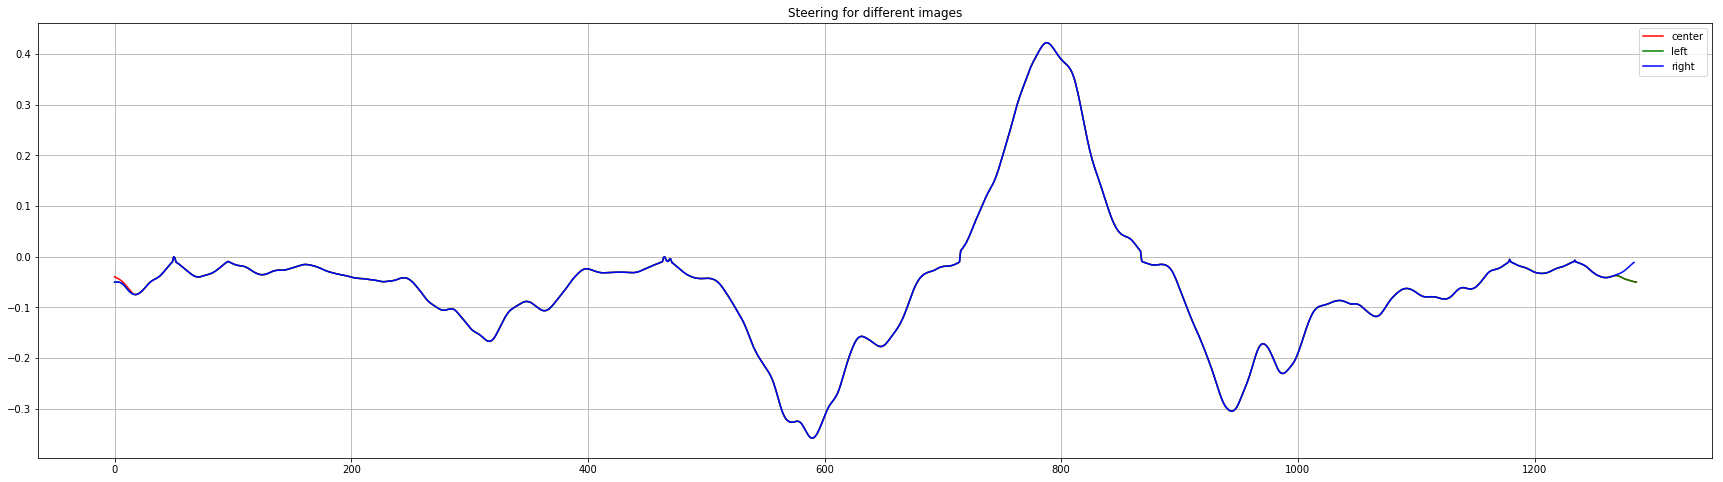

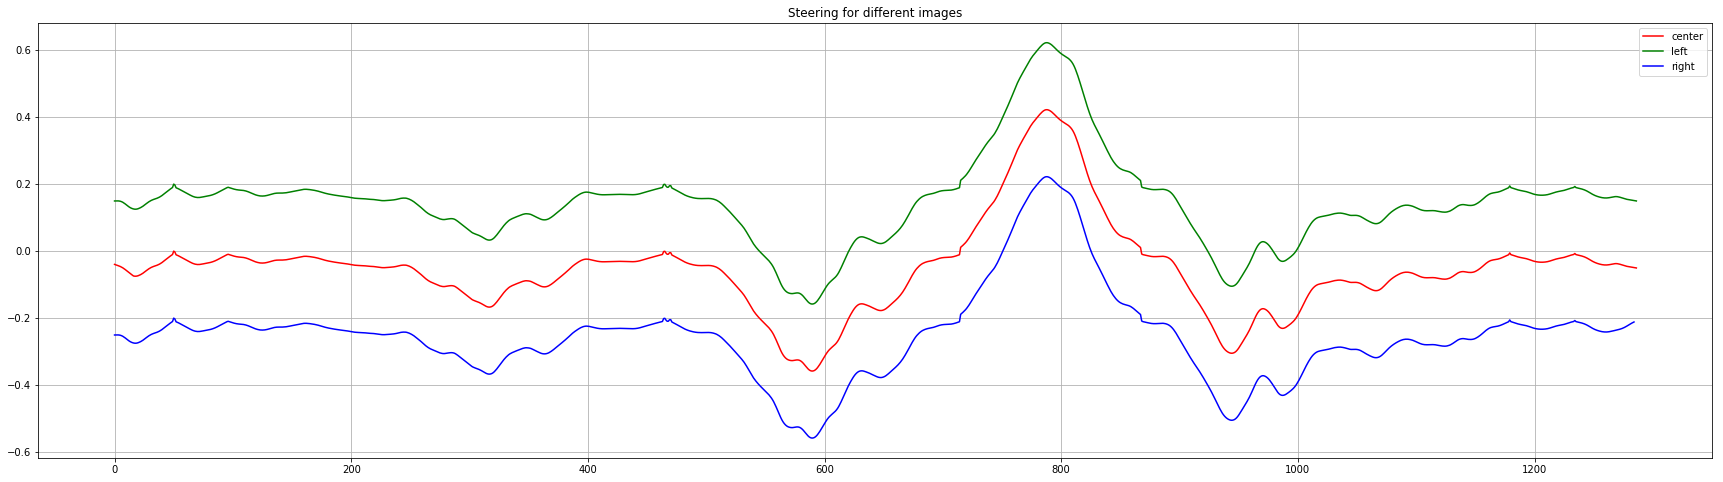

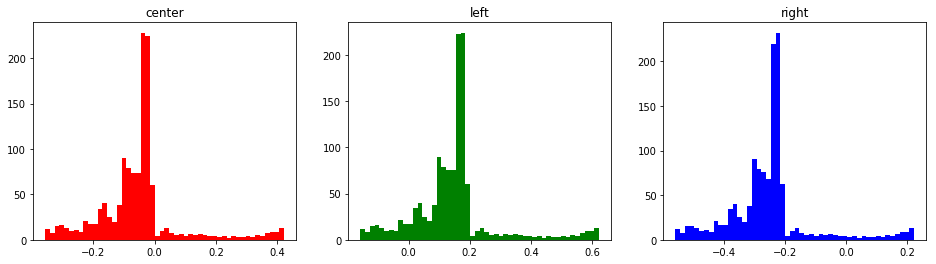

In [1]:
import utils
import numpy as np

path = 'data/track1-test/'
samples = utils.load_data(path,True)

### Model Architecture

I experimented with several models, including lenet, commaai, and nvidia model. The nnidia model turned out to perform very well so I decided to improve on this model. I first use Keras' lambda layer to normalize the data. And then use 3 convolution layers with max pooling layers before 3 fully connected layers. The final model looks like this: 


```python
def make_nvidia():
    model = make_preprocess_layers()
    model.add(Convolution2D(16, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(100, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(1))

    return model
```

In [4]:
import utils
model = utils.make_nvidia()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 80, 80, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 78, 78, 16)    448         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 39, 39, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 37, 37, 32)    4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

### Trainning Method
#### Reduce overfitting in the model

The model contains dropout layers in order to reduce overfitting. The model was trained and validated on different data sets to ensure that the model was not overfitting. The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track.

#### Model parameter tuning

The model used an adam optimizer, so the learning rate was not tuned manually .

#### Training data generator
During the training, a data generator is used to generate inifite batch of data. In each batch, I apply image flipping to increase the variety of the image. Since the environment in track one is fairly simply, I didn't apply other data augmentation method. But in real life, the situation is more complicated. For example, the light in different time of the day is different, there might be other traffic participants, etc.

Using TensorFlow backend.


Read  4305
Samples are reduce from  4305  to  3859
Generated a fresh batch


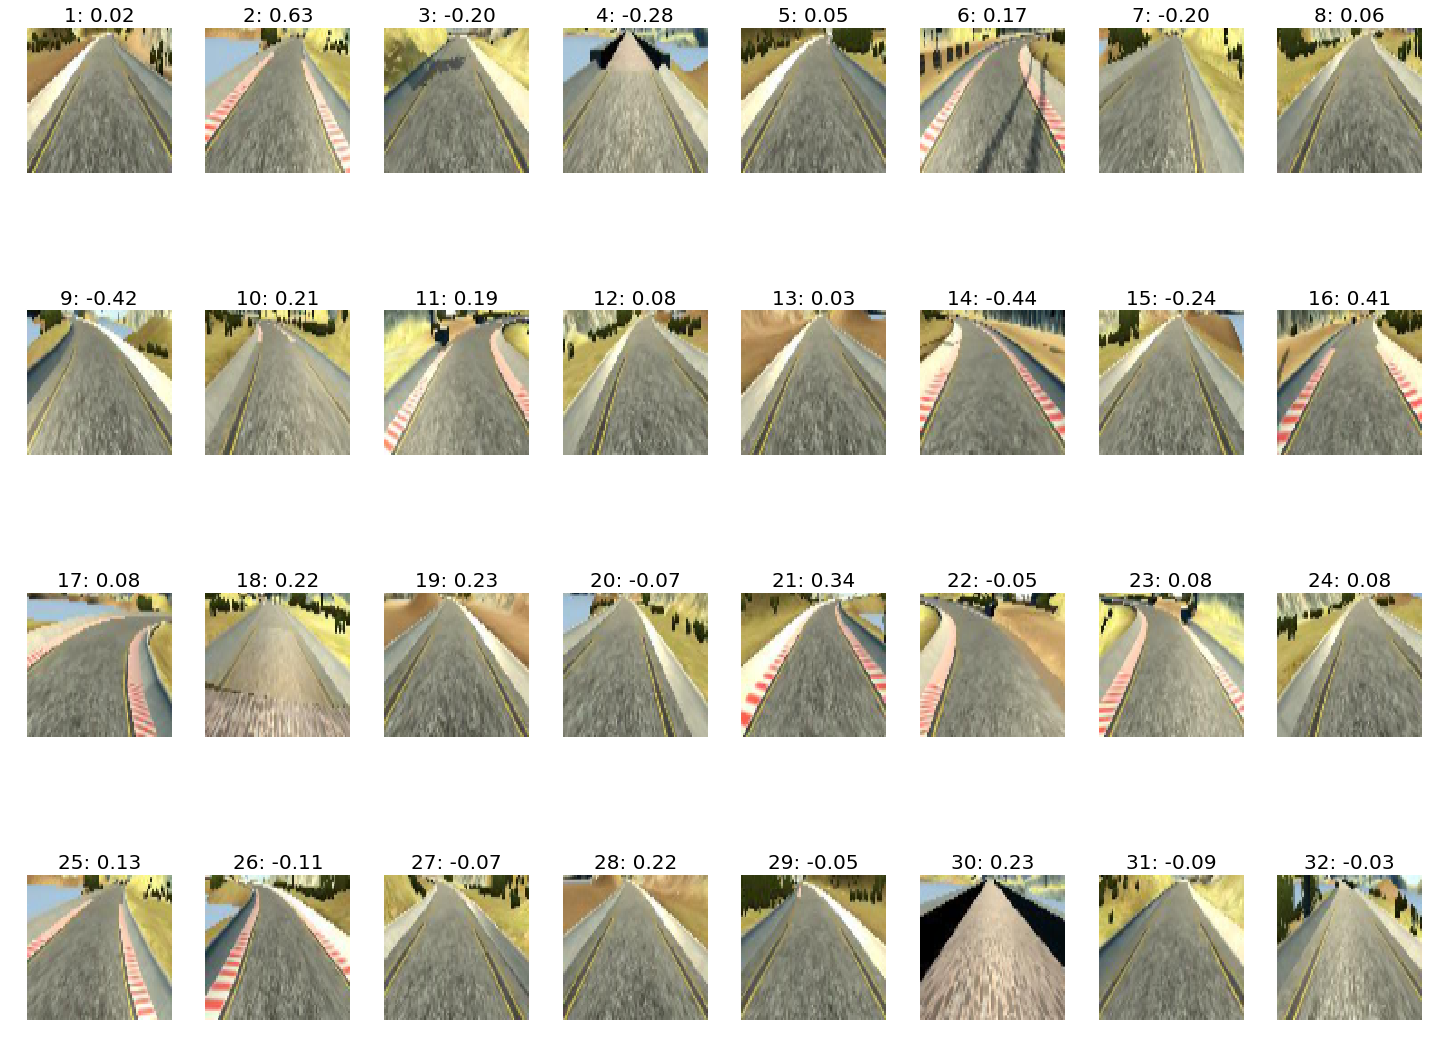

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt

path = 'data/track1-test/'
samples = utils.load_data(path)
gen = utils.generator(samples,32)
utils.plot_generator(gen)

Read  4305
Samples are reduce from  4305  to  3859
Testing prediction on 1930 images
MSE: 0.013108
Plotting results  78


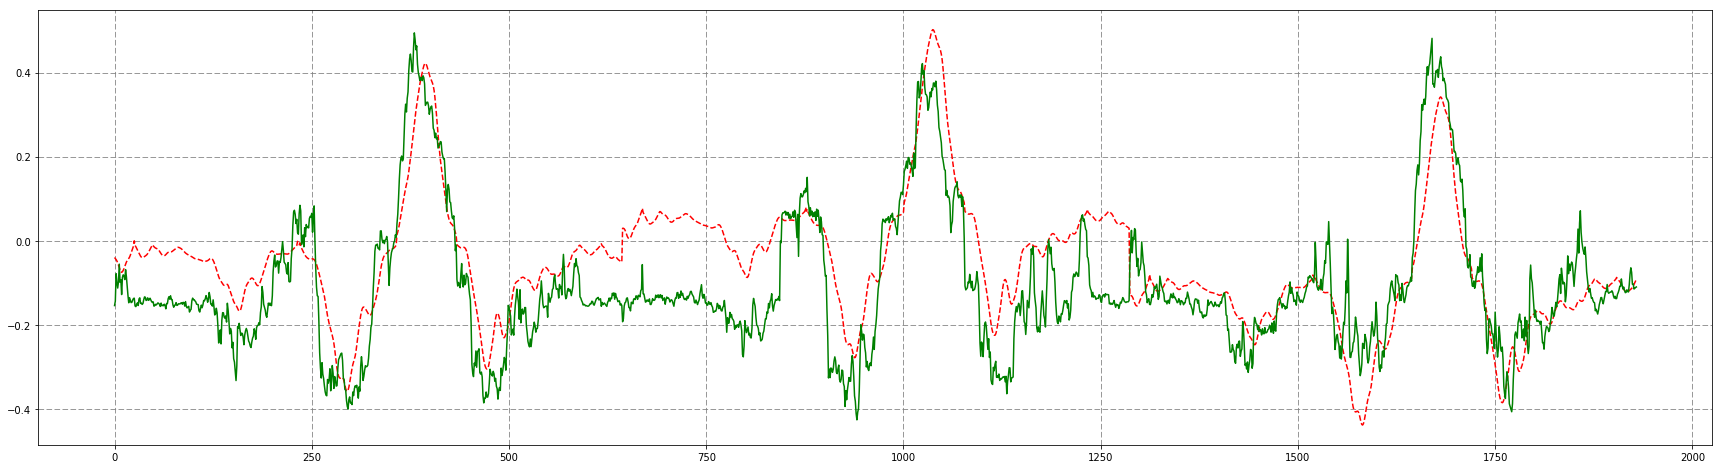

Result: [Ground truth | Prediction | Error]


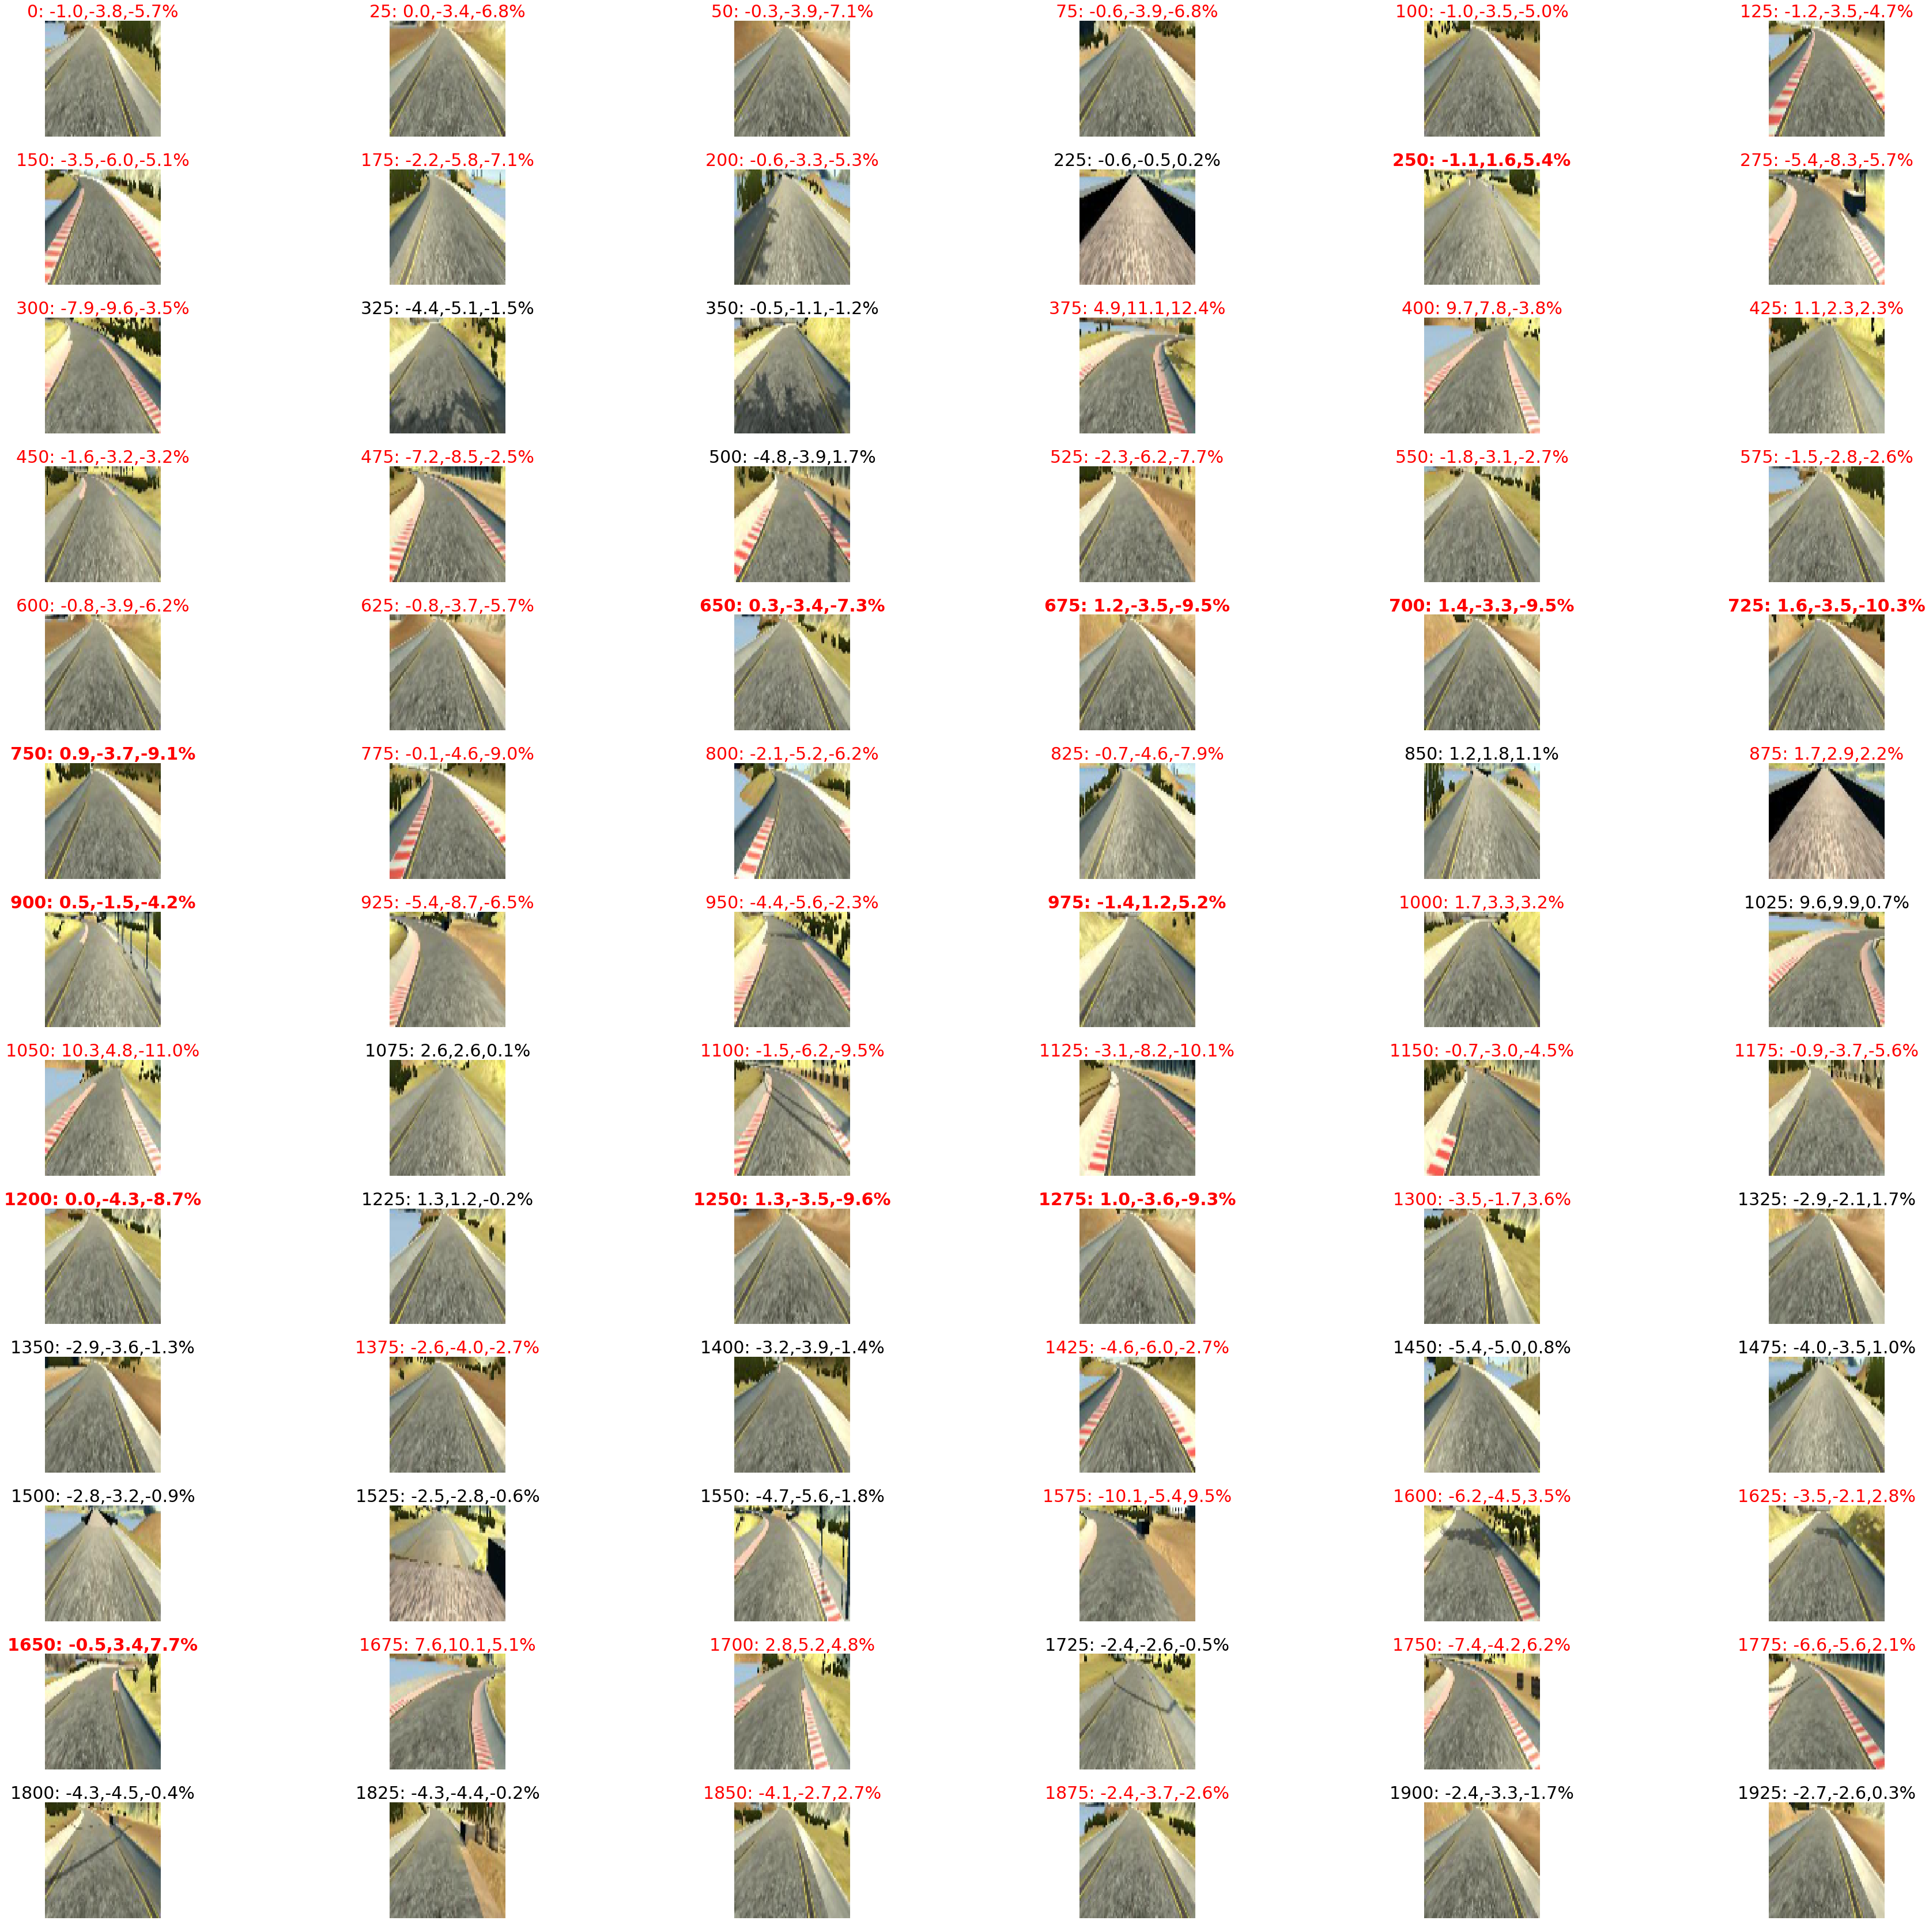

Test completed


In [5]:
import utils
utils.test_model('nvidia_t1_pro1.h5','data/track1-test/',True)

### Problem Encountered
The first problem I encountered was that the car always went off road after the bridge, where it's supposed to turn left but it turned slightly right. Also, sometimes the car just went crazy immediately when the test start. These two problems turn out to be caused by the different format of the cv2 images and PIL images. The default format of cv2 is BGR while the default of PIL is RGB. Since I always open and process the image with cv2 during the training but the drive.py uses PIL to load the image, the training loss is very low but it just doesn't work in the simulator.
Steering predict = 2.11 degree